In [2]:
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#import libraries for visualization of data
import matplotlib.pyplot as plt

In [3]:
np.random.seed(2022)
tf.random.set_seed(2022)
SEED = 2022
#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline
#paths to the train, validation and test image datasets 
train_path = 'D:/Code/Flutter/recycle/model/Garbage classification'
valid_path = 'D:/Code/Flutter/recycle/model/Garbage classification'

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [4]:
train_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='training',seed=SEED)

# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=  tf.keras.applications.mobilenet_v3.preprocess_input ,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(IMG_SIZE,IMG_SIZE), classes=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], batch_size=16, subset='validation',seed=SEED)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [12]:
train_batches[0][0][0].shape

(224, 224, 3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               492032    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

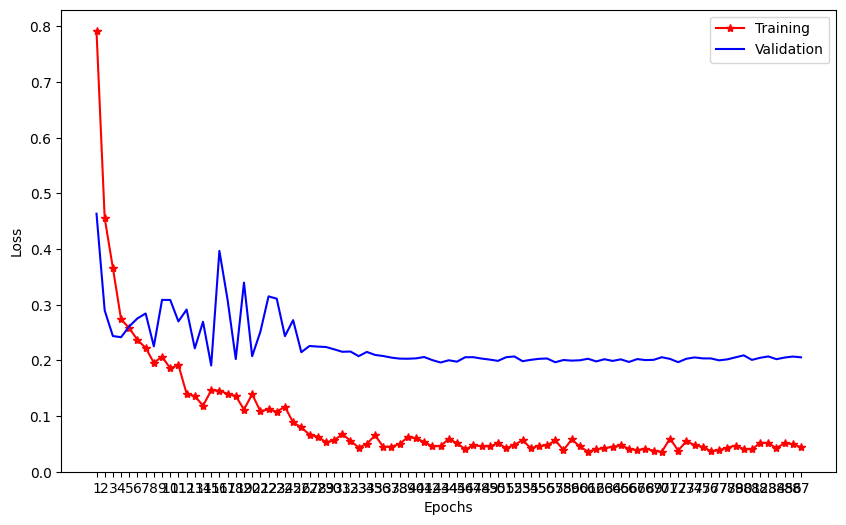

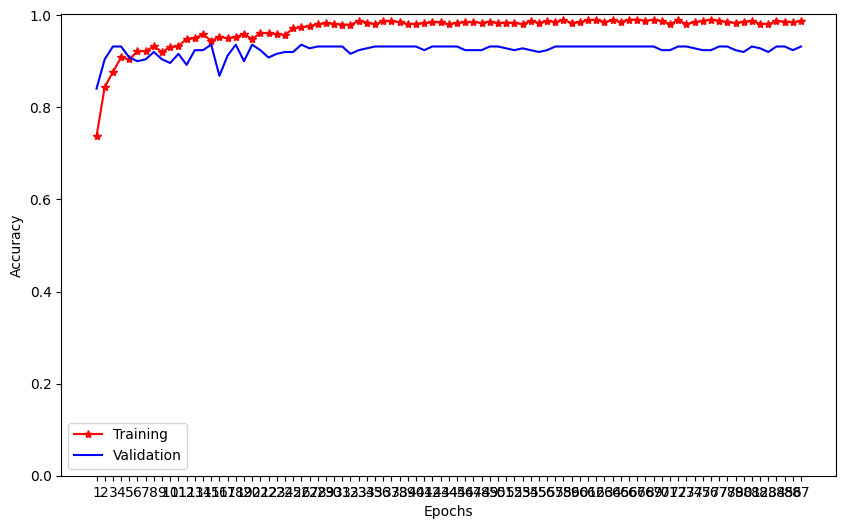

In [13]:


# import the convolution base of the VGG16 model with pre-trained weights
#base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE, 
                                       # include_top=False,
                                      #  weights='imagenet')
#base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
#model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE, alpha=1.0, include_top=False,
    weights='imagenet', pooling=None,
    dropout_rate=0.2)
model = Sequential()
# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated 
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               monitor='val_loss',
                               cooldown=0,
                               patience=10,
                               min_lr=0,
                               verbose=1,
                               mode='auto',
                               
                              )
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=30)
callbacks = [lr_reducer,es]


import time
start = time.time()
history = model.fit(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=50,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = callbacks)
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy =history.history['val_accuracy']
from tensorflow.keras import layers
for layer in model.layers[-150:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
#base_model.trainable=True
history = model.fit(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=50,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    callbacks = callbacks)
loss.extend(history.history['loss'])
validation_loss.extend(history.history['val_loss'])
accuracy.extend(history.history['accuracy'])
validation_accuracy.extend(history.history['val_accuracy'])
time_used = time.time()-start
print(time_used)


epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,'r*-',label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,max(plt.ylim())])
plt.xticks(epochs)
plt.legend()

epochs1 = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs1,accuracy,'r*-',label="Training")
plt.plot(epochs1,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,max(plt.ylim())])
plt.xticks(epochs1)
plt.legend()

def save_txt(file_name='',object=[]):
    file = open(file_name, 'w')
    file.write(str(object))
    file.close()

save_txt('./loss.txt',loss)
save_txt('./val_loss.txt',validation_loss)
save_txt('./acc.txt',accuracy)
save_txt('./val_acc.txt',validation_accuracy)
save_path='./mobilenetV3_parameter1_100_last150_10_30.h5'

model.save_weights(save_path)


In [14]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [ ]:
loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
loss1='categorical_crossentropy'
model.compile(optimizer=Adam(learning_rate=0.001), loss=loss1, metrics=['accuracy'])

In [ ]:
model.evaluate(valid_batches)

16/16 [==============================] - 2s 62ms/step - loss: 0.3157 - accuracy: 0.9163


[0.31572237610816956, 0.9163346886634827]

In [ ]:
calculate_acc=np.zeros([2,6])
label_acc=np.zeros([1,10])
for i in range(15):
    img_all,label_all= valid_batches[i]
#print(label_all)
    label=np.argmax(label_all,axis=1)
#print(label)
    prediction=model.predict(img_all)
#print(prediction) 
    predict_label_dig=np.argmax(prediction,axis=-1)
    for j in range(15):
        calculate_acc[0,label[j]]=calculate_acc[0,label[j]]+1
        if predict_label_dig[j] == label[j]:
            calculate_acc[1,predict_label_dig[j]]=calculate_acc[1,predict_label_dig[j]]+1

In [ ]:
evaluate_result=calculate_acc[1,:]/calculate_acc[0,:]
evaluate_result

array([0.93939394, 0.93617021, 1.        , 0.96153846, 0.81395349,
       0.83333333])